<a href="https://colab.research.google.com/github/giuliadascenzi/Homework2-Caltech101/blob/master/s287720Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [1]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import libraries**

In [2]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy

**Set Arguments**

In [44]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

PRETRAINED = False        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
FREEZE = 'no_freezing'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'

TRAIN_SIZE = 0.5     # split between training and validation sets

**Define Data Preprocessing**

In [4]:
if PRETRAINED : 
  mean, stdev = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) #mean and variance of ImageNet dataset
else :
  mean, stdev = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean, stdev) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, stdev)                                    
])

**Prepare Dataset**

In [5]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/giuliadascenzi/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset_giulia import Caltech

In [6]:
#function to split the training and validation indexes
def get_train_val_indexes(targets):
  from sklearn.model_selection import train_test_split
  import numpy as np
  train_idx, valid_idx= train_test_split(np.arange(len(targets)),
                                        test_size=0.5, #validation set must be half of the size of the original training set
                                        shuffle=True,
                                        stratify=targets)
  return train_idx, valid_idx



In [7]:
# Prepare Pytorch train/test Datasets
train_dataset_original = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# split the indices for your train split
# split the indices for your val split
train_indexes,val_indexes = get_train_val_indexes(train_dataset_original.data[1])

train_dataset = Subset(train_dataset_original, train_indexes)
val_dataset = Subset(train_dataset_original, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [8]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Plot some examples**

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


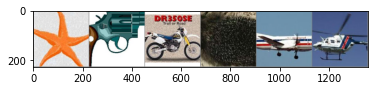

In [9]:
# Plot some samples
def imgshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return

x, y = next(iter(DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4, drop_last=True)))
out = torchvision.utils.make_grid(x)
imgshow(out)

**Prepare Network**

In [10]:
net = alexnet(pretrained=PRETRAINED, progress= True) # Loading AlexNet model 
                                          # pretrained (bool): If True, returns a model pre-trained on ImageNet
                                          # progress (bool): If True, displays a progress bar of the download to stderr

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d


# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [11]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

*Train function*

**Train**

In [12]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime


# save best config
best_net = 0
best_epoch = 0
best_val_acc = 0.0

# save accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []


current_step = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):

  print('>>> Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # ******************** TRAIN *****************************
  # Iterate over the dataset
  
  net.train() # Sets module in training mode

  running_corrects_train = 0
  running_loss_train = 0.0

  for images, labels in train_dataloader: #one batch at a time
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs_train = net(images)

    # Predictions
    _, preds = torch.max(outputs_train.data, 1) #to get the indexes of the maximum (predictions)
  
    # Compute loss based on output and ground truth
    loss = criterion(outputs_train, labels)

    #update data
    running_corrects_train += torch.sum(preds == labels.data).data.item() 
    running_loss_train += loss.item() * images.size(0)

    # Log loss
    #if current_step % LOG_FREQUENCY == 0:
    #  print('> Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  # ********************END TRAINING 1 EPOCH*****************
  
  # store loss and accuracy values (stats about the last epoch)
  train_acc = running_corrects_train / float(len(train_dataset))
  train_loss = running_loss_train / float(len(train_dataset))

  train_accuracies.append(train_acc)
  train_losses.append(train_loss) # loss computed as the average on mini-batches

  # ************** VALIDATION on TEMPORARY MODEL ************
  
  net.train(False) # Set Network to evaluation mode

  running_corrects_val = 0
  running_loss_val = 0.0

  for images, labels in (val_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs_val = net(images)

    print("outputs_val= ", outputs_val)
    # Get predictions
    _, preds = torch.max(outputs_val.data, 1)
    
    # Calculate Loss
    loss = criterion(outputs_val, labels)

    # Update Corrects and Loss
    running_loss_val += loss.item() * images.size(0)
    running_corrects_val += torch.sum(preds == labels.data).data.item()

    # Compute epoch loss and accuracy
  val_loss = running_loss_val / float(len(val_dataset))
  val_acc = running_corrects_val / float(len(val_dataset))

  # memorize stats 
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
  print(f">>Ended Epoch n*: {epoch+1}")
  print(f" Train Loss: {train_loss:.4f}")
  print(f" Validation Loss: {val_loss:.4f}")
  print(f" Train Accuracy: {train_acc:.4f}")  
  print(f" Validation Accuracy: {val_acc:.4f}")
  print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")


  # Check if the current epoch val accuracy is better than the best found until now
  if (val_acc >= best_val_acc) : 
    best_val_acc = val_acc
    best_epoch = epoch
    best_net = copy.deepcopy(net) # deep copy the model
  
  #************END VALIDATION******************
  # Step the scheduler
  scheduler.step() 

print(f"\nBest epoch: {best_epoch+1}\n{best_val_acc:.4f} (Validation Accuracy)\n")





>>> Starting epoch 1/30, LR = [0.001]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


outputs_val=  tensor([[ 0.0079,  0.0070, -0.0120,  ...,  0.0070, -0.0115,  0.0002],
        [ 0.0083,  0.0068, -0.0125,  ...,  0.0069, -0.0114,  0.0003],
        [ 0.0071,  0.0068, -0.0119,  ...,  0.0067, -0.0113,  0.0008],
        ...,
        [ 0.0080,  0.0074, -0.0130,  ...,  0.0073, -0.0116, -0.0003],
        [ 0.0088,  0.0066, -0.0117,  ...,  0.0068, -0.0113, -0.0010],
        [ 0.0073,  0.0070, -0.0124,  ...,  0.0066, -0.0119,  0.0002]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
outputs_val=  tensor([[ 8.0389e-03,  6.2916e-03, -1.3256e-02,  ...,  7.0227e-03,
         -1.1784e-02, -3.9883e-04],
        [ 8.5394e-03,  6.6740e-03, -1.1961e-02,  ...,  7.0346e-03,
         -1.1575e-02,  7.3049e-04],
        [ 8.1949e-03,  6.7492e-03, -1.1629e-02,  ...,  7.2079e-03,
         -1.1072e-02, -7.4931e-04],
        ...,
        [ 7.8113e-03,  6.9745e-03, -1.2225e-02,  ...,  6.9105e-03,
         -1.1679e-02, -3.1268e-05],
        [ 8.3625e-03,  7.2509e-03, -1.2102e-02,  ...,  7.2288e-

In [13]:
"train_losses",train_losses,"train_accuracies",train_accuracies,"val_losses",val_losses,"val_accuracies",val_accuracies



('train_losses',
 [4.493791720019666,
  4.492002030790759,
  4.489237931754085,
  4.486489619127118,
  4.483587705577888,
  4.480637884074062,
  4.477769400568919,
  4.474741955515754,
  4.471705815274356,
  4.468382944869467,
  4.465677559458204,
  4.462981164702736,
  4.459447836974844,
  4.455941607843296,
  4.452868027640906,
  4.449494969960235,
  4.445920403402706,
  4.442196794565288,
  4.437850129060231,
  4.432904930695129,
  4.430266532000994,
  4.430090982059885,
  4.429257890165759,
  4.429009190898383,
  4.427836733405191,
  4.427774727426954,
  4.426561115523427,
  4.426106770833333,
  4.425866386867328,
  4.425133838363373],
 'train_accuracies',
 [0.005186721991701245,
  0.007607192254495159,
  0.07261410788381743,
  0.09266943291839558,
  0.08713692946058091,
  0.09716459197786999,
  0.09439834024896265,
  0.09405255878284924,
  0.08782849239280774,
  0.09578146611341633,
  0.09612724757952974,
  0.09785615491009682,
  0.09578146611341633,
  0.09681881051175657,
  0.090

**Plotting after training**

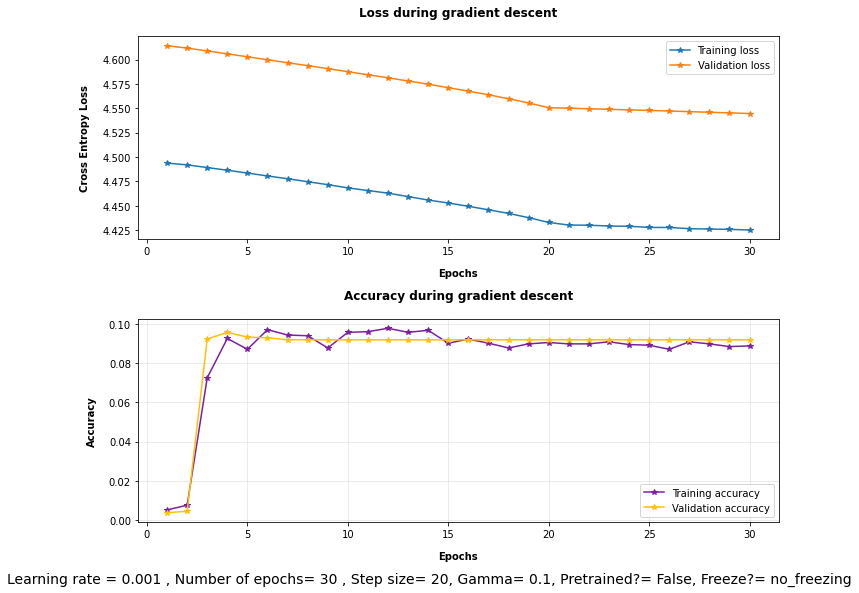

In [48]:
parameters = 'Learning rate = {LR} , Number of epochs= {NUM_EPOCHS} , Step size= {STEP_SIZE}, Gamma= {GAMMA}, Pretrained?= {PRETRAINED}, Freeze?= {FREEZE}'.format(LR=LR, NUM_EPOCHS=NUM_EPOCHS,STEP_SIZE=STEP_SIZE,GAMMA=GAMMA,PRETRAINED=PRETRAINED, FREEZE=FREEZE)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8), tight_layout=True)
fig.suptitle(parameters, fontsize=14, y=0)
epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax[0].plot(epochs,train_losses, linestyle='-', marker='*', label='Training loss')
ax[0].plot(epochs,val_losses, linestyle='-', marker='*', label='Validation loss')

ax[0].set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax[0].set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax[0].set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax[0].legend()
plt.grid(alpha=0.3)


# Plot accuracies

epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax[1].plot(epochs, train_accuracies, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax[1].plot(epochs, val_accuracies, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax[1].set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax[1].set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax[1].set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax[1].legend()
plt.grid(alpha=0.3)
plt.savefig('Caltech101/Graphs/default.png',bbox_inches="tight")
plt.show()


**Validation**

In [39]:
parameters

'Learning rate = 0.001 , Number of epochs= 30'

In [15]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 12/12 [00:14<00:00,  1.18s/it]

Validation Accuracy: 0.09197786998616875


**Test**

In [16]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 12/12 [00:14<00:00,  1.23s/it]

Test Accuracy: 0.09194607673695127


In [58]:
!cd Caltech101/
!ls
!git add ./Caltech101/
!git commit -m "added graph"
!git push

Caltech101  ciao.png  loss2.png  loss.png  sample_data
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
